<h2 style="margin-bottom: 18px">Index</h2>

* Imbalanced datasets
* The metric trap
* Confusion matrix
* Resampling
* Random under-sampling
* Random over-sampling
* Python imbalanced-learn module
* Random under-sampling and over-sampling with imbalanced-learn
* Under-sampling: Tomek links
* Under-sampling: Cluster Centroids
* Over-sampling: SMOTE
* Over-sampling followed by under-sampling
* Recommended reading

<h2 id="t1" style="margin-bottom: 18px">Imbalanced datasets</h2>

In this kernel we will know some techniques to handle highly unbalanced datasets, with a focus on resampling. The Porto Seguro's Safe Driver Prediction competition, used in this kernel, is a classic problem of unbalanced classes, since insurance claims can be considered unusual cases when considering all clients. Other classic examples of unbalanced classes are the detection of financial fraud and attacks on computer networks.

Let's see how unbalanced the dataset is:

In [1]:
import numpy as np
import pandas as pd

df_train = pd.read_csv('./input/train.csv')

target_count = df_train.target.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1


<h2 id="t2" style="margin-bottom: 18px">The metric trap</h2>

One of the major issues that novice users fall into when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like <code>accuracy_score</code> can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Let's do this experiment, using simple cross-validation and no feature engineering:

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = df_train.columns[2:]

X = df_train[labels]
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.36%


The high accuracy rate is just an illusion. In this way, the choice of the metric used in unbalanced datasets is extremely important. 

<h2 id="t3" style="margin-bottom: 18px">Confusion matrix</h2>

An interesting way to evaluate the results is by means of a confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. 

In the second row, we note that **all** class 1 entries were erroneously predicted as class 0.

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

Confusion matrix:
 [[114709      0]
 [  4334      0]]


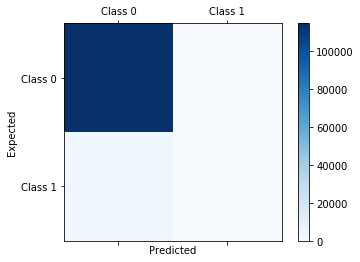

In [3]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

<h2 id="t4" style="margin-bottom: 18px">Resampling</h2>

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. 

It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

Let's implement a basic example, which uses the <code>DataFrame.sample</code> method to get random samples each class:

In [4]:
# Class count
count_class_0, count_class_1 = df_train.target.value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

<h2 id="t5">Random under-sampling</h2>

Random under-sampling:
1    21694
0    21694
Name: target, dtype: int64


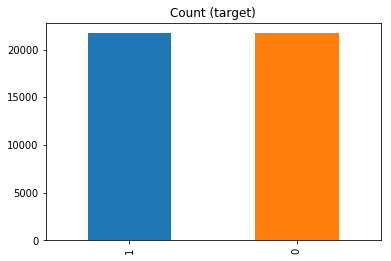

In [5]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.target.value_counts())

df_test_under.target.value_counts().plot(kind='bar', title='Count (target)');

<h2 id="t6">Random over-sampling</h2>

Random over-sampling:
1    573518
0    573518
Name: target, dtype: int64


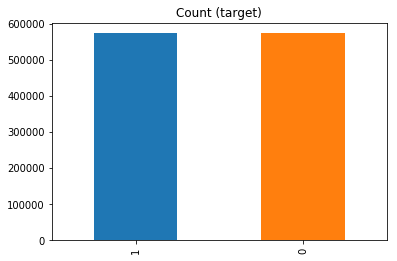

In [6]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.target.value_counts())

df_test_over.target.value_counts().plot(kind='bar', title='Count (target)');

<h2 id="t7" style="margin-bottom: 18px">Python imbalanced-learn module</h2>

A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/). It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

In [7]:
import imblearn

For ease of visualization, let's create a small unbalanced sample dataset using the <code>make_classification</code> method:

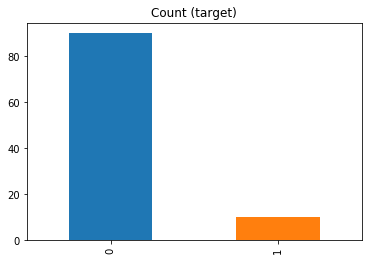

In [8]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');

We will also create a 2-dimensional plot function, <code>plot_2d_space</code>, to see the data distribution:

In [9]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

Because the dataset has many dimensions (features) and our graphs will be 2D, we will reduce the size of the dataset using Principal Component Analysis (PCA):

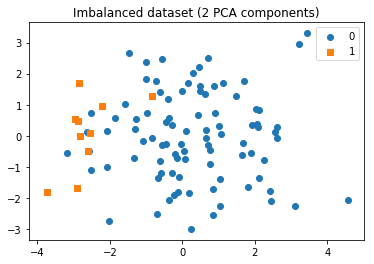

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

<h2 id="#t72">Random under-sampling and over-sampling with imbalanced-learn</h2>

Removed indexes: [65 46 25 11 56 35 55 82 42 95  4  8  9 14 16 40 67 70 71 74]


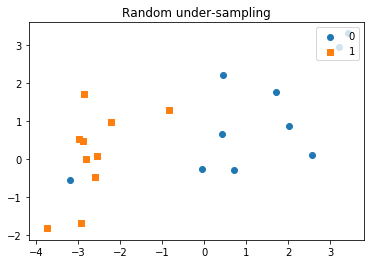

In [11]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

80 new random picked points


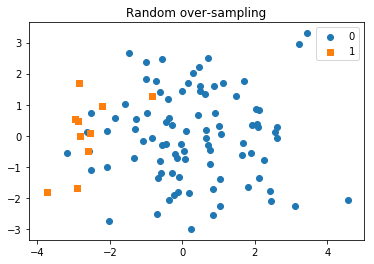

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

<h2 id="t8" style="margin-bottom: 18px">Under-sampling: Tomek links</h2>

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

In the code below, we'll use <code>ratio='majority'</code> to resample the majority class.

Removed indexes: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 90 91 92 93 94 95 97 98 99]


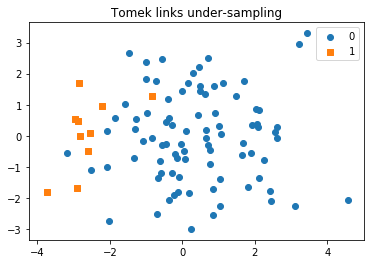

In [13]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

<h2 id="t9" style="margin-bottom: 18px">Under-sampling: Cluster Centroids</h2>

This technique performs under-sampling by generating centroids based on clustering methods. The data will be previously grouped by similarity, in order to preserve information.

In this example we will pass the <code>{0: 10}</code> dict for the parameter <code>ratio</code>, to preserve 10 elements from the majority class (0), and all minority class (1) .

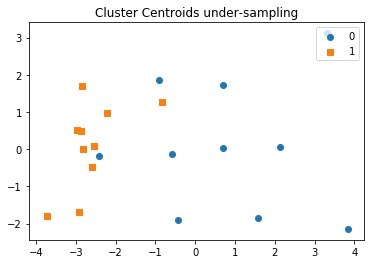

In [14]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={0: 10})
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

<h2 id="t10" style="margin-bottom: 18px">Over-sampling: SMOTE</h2>

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

 ![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

We'll use <code>ratio='minority'</code> to resample the minority class.

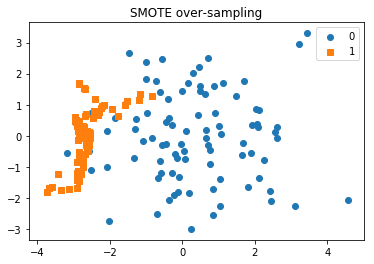

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

<h2 id="t11" style="margin-bottom: 18px">Over-sampling followed by under-sampling</h2>

Now, we will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques:

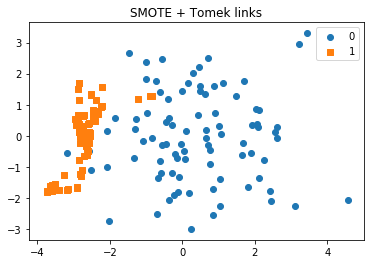

In [16]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

<h2 id="t12" style="margin-bottom: 18px">Recommended reading</h2>

The imbalanced-learn documentation:<br>
http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

The imbalanced-learn GitHub:<br>
https://github.com/scikit-learn-contrib/imbalanced-learn

Comparison of the combination of over- and under-sampling algorithms:<br>
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_comparison_combine.html

Chawla, Nitesh V., et al. "SMOTE: synthetic minority over-sampling technique." Journal of artificial intelligence research 16 (2002):<br>
https://www.jair.org/media/953/live-953-2037-jair.pdf